<a href="https://colab.research.google.com/github/wojciechsadlik/MelGAN-VC/blob/master/MelGAN_VC_conversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#We'll be using TF 2.1 and torchaudio

try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
!pip install soundfile                    #to save wav files
!pip install --no-deps torchaudio==0.5.0

In [2]:
#Connecting Drive to save model checkpoints during training and to use custom data, uncomment if needed

import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Imports

from __future__ import print_function, division
from glob import glob
import scipy
import soundfile as sf
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Concatenate, Conv2D, Conv2DTranspose, GlobalAveragePooling2D, UpSampling2D, LeakyReLU, ReLU, Add, Multiply, Lambda, Dot, BatchNormalization, Activation, ZeroPadding2D, Cropping2D, Cropping1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import TruncatedNormal, he_normal
import tensorflow.keras.backend as K
import datetime
import numpy as np
import random
import matplotlib.pyplot as plt
import collections
from PIL import Image
from skimage.transform import resize
import imageio
import librosa
import librosa.display
from librosa.feature import melspectrogram
import os
import time
import IPython

In [4]:
#Hyperparameters

hop=192               #hop size (window size = 6*hop)
sr=16000              #sampling rate
min_level_db=-100     #reference values to normalize data
ref_level_db=20

shape=24              #length of time axis of split specrograms to feed to generator            
vec_len=128           #length of vector generated by siamese vector
bs = 16               #batch size
delta = 2.            #constant for siamese loss

In [5]:
DATASET_BASE_PATH = '/content/drive/MyDrive/GTZAN_dataset'

In [6]:
#There seems to be a problem with Tensorflow STFT, so we'll be using pytorch to handle offline mel-spectrogram generation and waveform reconstruction
#For waveform reconstruction, a gradient-based method is used:

''' Decorsière, Rémi, Peter L. Søndergaard, Ewen N. MacDonald, and Torsten Dau. 
"Inversion of auditory spectrograms, traditional spectrograms, and other envelope representations." 
IEEE/ACM Transactions on Audio, Speech, and Language Processing 23, no. 1 (2014): 46-56.'''

#ORIGINAL CODE FROM https://github.com/yoyololicon/spectrogram-inversion

import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from functools import partial
import math
import heapq
from torchaudio.transforms import MelScale, Spectrogram

#torch.set_default_tensor_type('torch.cuda.FloatTensor')

specobj = Spectrogram(n_fft=6*hop, win_length=6*hop, hop_length=hop, pad=0, power=2, normalized=True)
specfunc = specobj.forward
melobj = MelScale(n_mels=hop, sample_rate=sr, f_min=0.)
melfunc = melobj.forward

def melspecfunc(waveform):
  specgram = specfunc(waveform)
  mel_specgram = melfunc(specgram)
  return mel_specgram

def spectral_convergence(input, target):
    return 20 * ((input - target).norm().log10() - target.norm().log10())

def GRAD(spec, transform_fn, samples=None, init_x0=None, maxiter=1000, tol=1e-6, verbose=1, evaiter=10, lr=0.003):

    spec = torch.Tensor(spec)
    samples = (spec.shape[-1]*hop)-hop

    if init_x0 is None:
        init_x0 = spec.new_empty((1,samples)).normal_(std=1e-6)
    x = nn.Parameter(init_x0)
    T = spec

    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam([x], lr=lr)

    bar_dict = {}
    metric_func = spectral_convergence
    bar_dict['spectral_convergence'] = 0
    metric = 'spectral_convergence'

    init_loss = None
    with tqdm(total=maxiter, disable=not verbose) as pbar:
        for i in range(maxiter):
            optimizer.zero_grad()
            V = transform_fn(x)
            loss = criterion(V, T)
            loss.backward()
            optimizer.step()
            lr = lr*0.9999
            for param_group in optimizer.param_groups:
              param_group['lr'] = lr

            if i % evaiter == evaiter - 1:
                with torch.no_grad():
                    V = transform_fn(x)
                    bar_dict[metric] = metric_func(V, spec).item()
                    l2_loss = criterion(V, spec).item()
                    pbar.set_postfix(**bar_dict, loss=l2_loss)
                    pbar.update(evaiter)

    return x.detach().view(-1).cpu()

def melspecfunc(waveform):
  specgram = specfunc(waveform)
  mel_specgram = melfunc(specgram)
  return mel_specgram

def normalize(S):
  return np.clip((((S - min_level_db) / -min_level_db)*2.)-1., -1, 1)

def denormalize(S):
  return (((np.clip(S, -1, 1)+1.)/2.) * -min_level_db) + min_level_db

def melprep(wv,hop=192):
  S = np.array(torch.squeeze(melspecfunc(torch.Tensor(wv).view(1,-1))).detach().cpu())
  S = librosa.power_to_db(S)-ref_level_db
  return normalize(S)

def stftprep(wv,hop=192):
  S = np.array(torch.squeeze(specfunc(torch.Tensor(wv).view(1,-1))).detach().cpu())
  S = librosa.power_to_db(S)-ref_level_db
  return normalize(S)

def meldeprep(S):
  S = denormalize(S)+ref_level_db
  S = librosa.db_to_power(S)
  wv = GRAD(np.expand_dims(S,0), melspecfunc, maxiter=2000, evaiter=10, tol=1e-8)
  return np.array(np.squeeze(wv))

def stftdeprep(S):
  S = denormalize(S)+ref_level_db
  S = librosa.db_to_power(S)
  wv = GRAD(np.expand_dims(S,0), specfunc, maxiter=2000, evaiter=10, tol=1e-8)
  return np.array(np.squeeze(wv))

In [7]:
#Adding Spectral Normalization to convolutional layers

from tensorflow.python.keras.utils import conv_utils
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import sparse_ops
from tensorflow.python.ops import gen_math_ops
from tensorflow.python.ops import standard_ops
from tensorflow.python.eager import context
from tensorflow.python.framework import tensor_shape

def l2normalize(v, eps=1e-12):
    return v / (tf.norm(v) + eps)


class ConvSN2D(tf.keras.layers.Conv2D):

    def __init__(self, filters, kernel_size, power_iterations=1, **kwargs):
        super(ConvSN2D, self).__init__(filters, kernel_size, **kwargs)
        self.power_iterations = power_iterations


    def build(self, input_shape):
        super(ConvSN2D, self).build(input_shape)

        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1

        self.u = self.add_weight(self.name + '_u',
            shape=tuple([1, self.kernel.shape.as_list()[-1]]), 
            initializer=tf.initializers.RandomNormal(0, 1),
            trainable=False
        )

    def compute_spectral_norm(self, W, new_u, W_shape):
        for _ in range(self.power_iterations):

            new_v = l2normalize(tf.matmul(new_u, tf.transpose(W)))
            new_u = l2normalize(tf.matmul(new_v, W))
            
        sigma = tf.matmul(tf.matmul(new_v, W), tf.transpose(new_u))
        W_bar = W/sigma

        with tf.control_dependencies([self.u.assign(new_u)]):
          W_bar = tf.reshape(W_bar, W_shape)

        return W_bar


    def call(self, inputs):
        W_shape = self.kernel.shape.as_list()
        W_reshaped = tf.reshape(self.kernel, (-1, W_shape[-1]))
        new_kernel = self.compute_spectral_norm(W_reshaped, self.u, W_shape)
        outputs = self.convolution_op(inputs, new_kernel)

        if self.use_bias:
            if self.data_format == 'channels_first':
                    outputs = tf.nn.bias_add(outputs, self.bias, data_format='NCHW')
            else:
                outputs = tf.nn.bias_add(outputs, self.bias, data_format='NHWC')
        if self.activation is not None:
            return self.activation(outputs)

        return outputs


class ConvSN2DTranspose(tf.keras.layers.Conv2DTranspose):

    def __init__(self, filters, kernel_size, power_iterations=1, **kwargs):
        super(ConvSN2DTranspose, self).__init__(filters, kernel_size, **kwargs)
        self.power_iterations = power_iterations


    def build(self, input_shape):
        super(ConvSN2DTranspose, self).build(input_shape)

        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1

        self.u = self.add_weight(self.name + '_u',
            shape=tuple([1, self.kernel.shape.as_list()[-1]]), 
            initializer=tf.initializers.RandomNormal(0, 1),
            trainable=False
        )

    def compute_spectral_norm(self, W, new_u, W_shape):
        for _ in range(self.power_iterations):

            new_v = l2normalize(tf.matmul(new_u, tf.transpose(W)))
            new_u = l2normalize(tf.matmul(new_v, W))
            
        sigma = tf.matmul(tf.matmul(new_v, W), tf.transpose(new_u))
        W_bar = W/sigma

        with tf.control_dependencies([self.u.assign(new_u)]):
          W_bar = tf.reshape(W_bar, W_shape)

        return W_bar

    def call(self, inputs):
        W_shape = self.kernel.shape.as_list()
        W_reshaped = tf.reshape(self.kernel, (-1, W_shape[-1]))
        new_kernel = self.compute_spectral_norm(W_reshaped, self.u, W_shape)

        inputs_shape = array_ops.shape(inputs)
        batch_size = inputs_shape[0]
        if self.data_format == 'channels_first':
          h_axis, w_axis = 2, 3
        else:
          h_axis, w_axis = 1, 2

        height, width = inputs_shape[h_axis], inputs_shape[w_axis]
        kernel_h, kernel_w = self.kernel_size
        stride_h, stride_w = self.strides

        if self.output_padding is None:
          out_pad_h = out_pad_w = None
        else:
          out_pad_h, out_pad_w = self.output_padding

        out_height = conv_utils.deconv_output_length(height,
                                                    kernel_h,
                                                    padding=self.padding,
                                                    output_padding=out_pad_h,
                                                    stride=stride_h,
                                                    dilation=self.dilation_rate[0])
        out_width = conv_utils.deconv_output_length(width,
                                                    kernel_w,
                                                    padding=self.padding,
                                                    output_padding=out_pad_w,
                                                    stride=stride_w,
                                                    dilation=self.dilation_rate[1])
        if self.data_format == 'channels_first':
          output_shape = (batch_size, self.filters, out_height, out_width)
        else:
          output_shape = (batch_size, out_height, out_width, self.filters)

        output_shape_tensor = array_ops.stack(output_shape)
        outputs = K.conv2d_transpose(
            inputs,
            new_kernel,
            output_shape_tensor,
            strides=self.strides,
            padding=self.padding,
            data_format=self.data_format,
            dilation_rate=self.dilation_rate)

        if not context.executing_eagerly():
          out_shape = self.compute_output_shape(inputs.shape)
          outputs.set_shape(out_shape)

        if self.use_bias:
          outputs = tf.nn.bias_add(
              outputs,
              self.bias,
              data_format=conv_utils.convert_data_format(self.data_format, ndim=4))

        if self.activation is not None:
          return self.activation(outputs)
        return outputs  
    
    
class DenseSN(Dense):
    
    def build(self, input_shape):
        super(DenseSN, self).build(input_shape)

        self.u = self.add_weight(self.name + '_u',
            shape=tuple([1, self.kernel.shape.as_list()[-1]]), 
            initializer=tf.initializers.RandomNormal(0, 1),
            trainable=False)
        
    def compute_spectral_norm(self, W, new_u, W_shape):
        new_v = l2normalize(tf.matmul(new_u, tf.transpose(W)))
        new_u = l2normalize(tf.matmul(new_v, W))
        sigma = tf.matmul(tf.matmul(new_v, W), tf.transpose(new_u))
        W_bar = W/sigma
        with tf.control_dependencies([self.u.assign(new_u)]):
          W_bar = tf.reshape(W_bar, W_shape)
        return W_bar
        
    def call(self, inputs):
        W_shape = self.kernel.shape.as_list()
        W_reshaped = tf.reshape(self.kernel, (-1, W_shape[-1]))
        new_kernel = self.compute_spectral_norm(W_reshaped, self.u, W_shape)
        rank = len(inputs.shape)
        if rank > 2:
          outputs = standard_ops.tensordot(inputs, new_kernel, [[rank - 1], [0]])
          if not context.executing_eagerly():
            shape = inputs.shape.as_list()
            output_shape = shape[:-1] + [self.units]
            outputs.set_shape(output_shape)
        else:
          inputs = math_ops.cast(inputs, self._compute_dtype)
          if K.is_sparse(inputs):
            outputs = sparse_ops.sparse_tensor_dense_matmul(inputs, new_kernel)
          else:
            outputs = gen_math_ops.mat_mul(inputs, new_kernel)
        if self.use_bias:
          outputs = tf.nn.bias_add(outputs, self.bias)
        if self.activation is not None:
          return self.activation(outputs)
        return outputs


In [8]:
#Networks Architecture

init = tf.keras.initializers.he_uniform()

def conv2d(layer_input, filters, kernel_size=4, strides=2, padding='same', leaky=True, bnorm=True, sn=True):
  if leaky:
    Activ = LeakyReLU(alpha=0.2)
  else:
    Activ = ReLU()
  if sn:
    d = ConvSN2D(filters, kernel_size=kernel_size, strides=strides, padding=padding, kernel_initializer=init, use_bias=False)(layer_input)
  else:
    d = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding=padding, kernel_initializer=init, use_bias=False)(layer_input)
  if bnorm:
    d = BatchNormalization()(d)
  d = Activ(d)
  return d

def deconv2d(layer_input, layer_res, filters, kernel_size=4, conc=True, scalev=False, bnorm=True, up=True, padding='same', strides=2):
  if up:
    u = UpSampling2D((1,2))(layer_input)
    u = ConvSN2D(filters, kernel_size, strides=(1,1), kernel_initializer=init, use_bias=False, padding=padding)(u)
  else:
    u = ConvSN2DTranspose(filters, kernel_size, strides=strides, kernel_initializer=init, use_bias=False, padding=padding)(layer_input)
  if bnorm:
    u = BatchNormalization()(u)
  u = LeakyReLU(alpha=0.2)(u)
  if conc:
    u = Concatenate()([u,layer_res])
  return u

#Extract function: splitting spectrograms
def extract_image(im):
  im1 = Cropping2D(((0,0), (0, 2*(im.shape[2]//3))))(im)
  im2 = Cropping2D(((0,0), (im.shape[2]//3,im.shape[2]//3)))(im)
  im3 = Cropping2D(((0,0), (2*(im.shape[2]//3), 0)))(im)
  return im1,im2,im3

#Assemble function: concatenating spectrograms
def assemble_image(lsim):
  im1,im2,im3 = lsim
  imh = Concatenate(2)([im1,im2,im3])
  return imh

#U-NET style architecture
def build_generator(input_shape):
  h,w,c = input_shape
  inp = Input(shape=input_shape)
  #downscaling
  g0 = tf.keras.layers.ZeroPadding2D((0,1))(inp)
  g1 = conv2d(g0, 256, kernel_size=(h,3), strides=1, padding='valid')
  g2 = conv2d(g1, 256, kernel_size=(1,9), strides=(1,2))
  g3 = conv2d(g2, 256, kernel_size=(1,7), strides=(1,2))
  #upscaling
  g4 = deconv2d(g3,g2, 256, kernel_size=(1,7), strides=(1,2))
  g5 = deconv2d(g4,g1, 256, kernel_size=(1,9), strides=(1,2), bnorm=False)
  g6 = ConvSN2DTranspose(1, kernel_size=(h,1), strides=(1,1), kernel_initializer=init, padding='valid', activation='tanh')(g5)
  return Model(inp,g6, name='G')

#Siamese Network
def build_siamese(input_shape):
  h,w,c = input_shape
  inp = Input(shape=input_shape)
  g1 = conv2d(inp, 256, kernel_size=(h,3), strides=1, padding='valid', sn=False)
  g2 = conv2d(g1, 256, kernel_size=(1,9), strides=(1,2), sn=False)
  g3 = conv2d(g2, 256, kernel_size=(1,7), strides=(1,2), sn=False)
  g4 = Flatten()(g3)
  g5 = Dense(vec_len)(g4)
  return Model(inp, g5, name='S')

#Discriminator (Critic) Network
def build_critic(input_shape):
  h,w,c = input_shape
  inp = Input(shape=input_shape)
  g1 = conv2d(inp, 512, kernel_size=(h,3), strides=1, padding='valid', bnorm=False)
  g2 = conv2d(g1, 512, kernel_size=(1,9), strides=(1,2), bnorm=False)
  g3 = conv2d(g2, 512, kernel_size=(1,7), strides=(1,2), bnorm=False)
  g4 = Flatten()(g3)
  g4 = DenseSN(1, kernel_initializer=init)(g4)
  return Model(inp, g4, name='C')

In [9]:
#Load past models from path to resume training or test
def load(path):
  gen = build_generator((hop,shape,1))
  siam = build_siamese((hop,shape,1))
  critic = build_critic((hop,3*shape,1))
  gen.load_weights(path+'/gen.h5')
  critic.load_weights(path+'/critic.h5')
  siam.load_weights(path+'/siam.h5')
  return gen,critic,siam

#Build models
def build():
  gen = build_generator((hop,shape,1))
  siam = build_siamese((hop,shape,1))
  critic = build_critic((hop,3*shape,1))                                          #the discriminator accepts as input spectrograms of triple the width of those generated by the generator
  return gen,critic,siam

In [10]:
#Get models and optimizers
def get_networks(shape, load_model=False, path=None):
  if not load_model:
    gen,critic,siam = build()
  else:
    gen,critic,siam = load(path)
  print('Built networks')

  opt_gen = Adam(0.0001, 0.5)
  opt_disc = Adam(0.0001, 0.5)

  return gen,critic,siam, [opt_gen,opt_disc]

In [11]:
#Build models and initialize optimizers

#If load_model=True, specify the path where the models are saved

gen,critic,siam, [opt_gen,opt_disc] = get_networks(shape, load_model=True,
                                        path=os.path.join(DATASET_BASE_PATH, 'genres_melspectrograms', 'jazz-classical', 'MELGANVC-1.1434205-0.31449-0.2184808'))

Built networks


In [14]:
#After Training, use these functions to convert data with the generator and save the results

#Assembling generated Spectrogram chunks into final Spectrogram
def specass(a,spec):
  but=False
  con = np.array([])
  nim = a.shape[0]
  for i in range(nim-1):
    im = a[i]
    im = np.squeeze(im)
    if not but:
      con=im
      but=True
    else:
      con = np.concatenate((con,im), axis=1)
  diff = spec.shape[1]-(nim*shape)
  a = np.squeeze(a)
  con = np.concatenate((con,a[-1,:,-diff:]), axis=1)
  return np.squeeze(con)

#Splitting input spectrogram into different chunks to feed to the generator
def chopspec(spec):
  dsa=[]
  for i in range(spec.shape[1]//shape):
    im = spec[:,i*shape:i*shape+shape]
    im = np.reshape(im, (im.shape[0],im.shape[1],1))
    dsa.append(im)
  imlast = spec[:,-shape:]
  imlast = np.reshape(imlast, (imlast.shape[0],imlast.shape[1],1))
  dsa.append(imlast)
  return np.array(dsa, dtype=np.float32)

#Converting from source Spectrogram to target Spectrogram
def towave(spec, name, path='../content/', show=False):
  specarr = chopspec(spec)
  print(specarr.shape)
  a = specarr
  print('Generating...')
  ab = gen(a, training=False)
  print('Assembling and Converting...')
  a = specass(a,spec)
  ab = specass(ab,spec)
  #awv = meldeprep(a)
  abwv = meldeprep(ab)
  print('Saving...')
  pathfin = f'{path}/{name}'
  os.mkdir(pathfin)
  sf.write(pathfin+'/AB.wav', abwv, sr)
  #sf.write(pathfin+'/A.wav', awv, sr)
  print('Saved WAV!')
  IPython.display.display(IPython.display.Audio(np.squeeze(abwv), rate=sr))
  #IPython.display.display(IPython.display.Audio(np.squeeze(awv), rate=sr))
  if show:
    fig, axs = plt.subplots(ncols=2)
    axs[0].imshow(np.flip(a, -2), cmap=None)
    axs[0].axis('off')
    axs[0].set_title('Source')
    axs[1].imshow(np.flip(ab, -2), cmap=None)
    axs[1].axis('off')
    axs[1].set_title('Generated')
    plt.show()
  return abwv

(480214,)


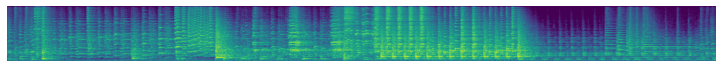

(105, 192, 24, 1)
Generating...
Assembling and Converting...


100%|██████████| 2000/2000 [13:50<00:00,  2.41it/s, loss=0.000117, spectral_convergence=-8.55]

Saving...
Saved WAV!


In [15]:
#Wav to wav conversion

FILE_PATH = os.path.join(DATASET_BASE_PATH, 'genres_original', 'jazz', 'jazz.00000.wav')

wv, sr = librosa.load(FILE_PATH, sr=16000)  #Load waveform
print(wv.shape)
speca = melprep(wv)                                                    #Waveform to Spectrogram

plt.figure(figsize=(50,1))                                          #Show Spectrogram
plt.imshow(np.flip(speca, axis=0), cmap=None)
plt.axis('off')
plt.show()

abwv = towave(speca, name='converted', path='../content/')           #Convert and save wav